# Problem Sheet 4- The CUR factorization
**Submission until November 28 at 5 p.m. in the corresponding folder in StudIP.** \
In this exercise we consider the CUR decomposition as a special case of the CX decomposition. For a matrix $A \in \mathbb{R}^{m,n}$ it is defined as $$A \approx C U R$$ with $C \in \mathbb{R}^{m,k}$, $U \in \mathbb{R}^{k,k}$ and $R \in \mathbb{R}^{k,n}$. The important idea is that $C$ contains columns of $A$ and $R$ contains rows of $A$.



We choose $k$ as the number of columns and rows we want to use and store the column and the row indices as vectors $p$ and $q$, respectively. The first test will be with a simple 4 by 3 matrix.

**Task: Given $p$ and $q$ recall from the lecture how to compute the intersection matrix $U$ using left and right inverses $Y^\top = C^+, Z = R^+$ and complete the following code. (2 Points)**

In [1]:
import numpy as np

A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]])
k = 2
p = np.array([0, 3])
q = np.array([1, 2])

C = A[:,q]
R = A[p,:]

U = np.linalg.pinv(C)@A@np.linalg.pinv(R)

CUR = C @ U @ R

print(A)
print(CUR)

[[1 5 8]
 [3 9 1]
 [4 5 4]
 [0 9 2]]
[[ 1.01967367  4.97129958  8.12915189]
 [-0.10095332  8.93550837  1.29021234]
 [ 0.44165399  4.96746947  4.14638739]
 [ 0.0435516   8.9364659   2.28590346]]


As you can see, we get an approximation of $A$, but we chose $p$ and $q$ randomly. In the following we want to implement the two heuristics for finding good values $p$ and $q$.  

The first heuristic is very simple - **leverage scores**.  Remember from the lecture that leverage scores are obtained via the truncated SVD.

**Task: Write a function that computes the row and column leverage scores and takes the matrix and a rank $k$ as input. The function should return the vectors $p$ and $q$. (4 Points)**

In [2]:
from scipy.sparse.linalg import svds, eigs

def leverageScores(A, k):
    u,_,v = svds(A.astype(float),k)
    p = (np.argsort(np.linalg.norm(u,axis=1)))[-k:]
    q = (np.argsort(np.linalg.norm(v,axis=0)))[-k:]
    return p, q

Test your function using the following code snippet. Note that the order of the indices is not important.

In [3]:
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
k = 2
p_correct = [0,1]
q_correct = [1,2]

p, q = leverageScores(A, k) #your function here

print("Your indices:")
print("p = ", p)
print("q = ", q)

print("Correct indices:")
print("p = ", p_correct)
print("q = ", q_correct)

Your indices:
p =  [1 0]
q =  [1 2]
Correct indices:
p =  [0, 1]
q =  [1, 2]


**Task: Combine our previous work to a CUR_leverage method that computes the CUR approximaton via leverage scores. (4 Points)** The function head should look like this:

```
CUR_leverage(A, k)
```
The function should return the three matrices $C$, $U$, and $R$.



In [4]:
def CUR_leverage(A, k):
    p,q = leverageScores(A,k)
    C = A[:,q]
    R = A[p,:]
    U = np.linalg.pinv(C)@A@np.linalg.pinv(R)
    return C, U, R

Let's look at the absolute and relative $\ell_2$ error.

In [5]:
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
C, U, R = CUR_leverage(A, 2)
print("absolute error: ", np.linalg.norm(A - (C@U@R)))
print("relative error: ", np.linalg.norm(A - (C@U@R))/np.linalg.norm(A))

absolute error:  3.8898153368702855
relative error:  0.21643511497365037


### Points 10/10

Now, we want to implement the second heuristic based on projections. 

**Task: Implement the algorithm based on projections to compute $p$ from the lecture and use the same concept to implement an algorithm for $q$. (4 Points)**

In [6]:
def interpolation(A, k): 
    uh,_,vh = svds(A.astype(float),k)
    q=[]
    v = vh[0,:]
    q.append(np.argmax(np.abs(v)))
    for i in range(1,k):
        v = vh[i,:]
        #v[q[i-1]] = 0 skript says this below also works
        v[q] = 0
        q.append(np.argmax(np.abs(v)))
        
    p=[]
    u = uh[:,0]
    p.append(np.argmax(np.abs(u)))
    for i in range(1,k):
        u = uh[:,i]
        #u[p[i-1]] = 0
        u[p] = 0
        p.append(np.argmax(np.abs(u)))
        
    return np.array(p), np.array(q)

Test the algorithm on the following example as before.

In [7]:
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
k = 2
p_correct = [0,1]
q_correct = [1,2]

p, q = interpolation(A, k) #your function here

print("Your indices:")
print("p = ", p)
print("q = ", q)

print("Correct indices:")
print("p = ", p_correct)
print("q = ", q_correct)

Your indices:
p =  [0 1]
q =  [2 1]
Correct indices:
p =  [0, 1]
q =  [1, 2]


**Task: Combine our previous work to a CUR_interpolation method that computes the CUR approximaton via the projection approach. (4 Points)** The function head should look like this:

```
CUR_interpolation(A, k)
```
The function should return the three matrices $C$, $U$, and $R$.

In [8]:
def CUR_interpolation(A, k):
    p,q = interpolation(A,k)
    C = A[:,q]
    R = A[p,:]
    U = np.linalg.pinv(C)@A@np.linalg.pinv(R)
    return C, U, R

Let's look at the absolute and relative $\ell_2$ error.

In [9]:
A = np.array([[1, 5, 8], [3, 9, 1], [4, 5, 4], [0, 9, 2]], dtype=float)
C, U, R = CUR_interpolation(A, 2)
print("absolute error: ", np.linalg.norm(A - (C@U@R)))
print("relative error: ", np.linalg.norm(A - (C@U@R))/np.linalg.norm(A))

absolute error:  3.889815336870285
relative error:  0.21643511497365034


### Points 8/8

# Applications

Having implemented both CUR variants, we want to apply and compare them on different examples. The first example is an RGB image of a baboon that we transform into a grayscale image to make it applicable to a CUR decomposition. Execute the following code to visualize the original image and the two CUR approximations. Which one looks better? (1 Point)  
Clear ranking here svd > interpolation > leverage

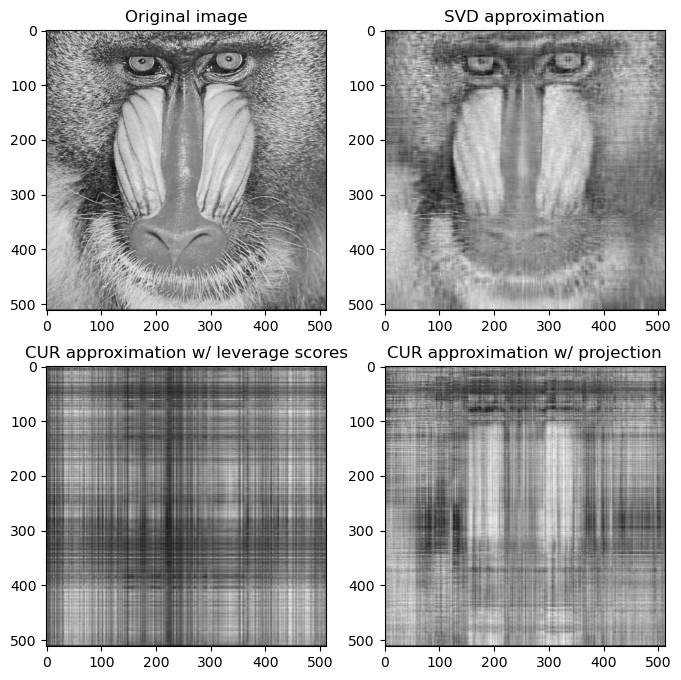

SVD relative error:  0.1715824744403016
CUR leverage relative error:  0.36035300737192866
CUR interpolation relative error:  0.25656920627427177


In [10]:
from PIL import Image
import matplotlib.pyplot as plt

k = 20

im = np.asarray(Image.open('baboon.png').convert('L'), dtype=float)

U, S, Vt = svds(im, k=k)

C1, U1, R1 = CUR_leverage(im,k)
C2, U2, R2 = CUR_interpolation(im,k)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('Original image')
plt.imshow(im, cmap='gray')
plt.subplot(222)
plt.imshow((U@np.diag(S)@Vt), cmap='gray')
plt.title('SVD approximation')
plt.subplot(223)
plt.imshow((C1@U1@R1), cmap='gray')
plt.title('CUR approximation w/ leverage scores')
plt.subplot(224)
plt.imshow((C2@U2@R2), cmap='gray')
plt.title('CUR approximation w/ projection')
plt.show()

print("SVD relative error: ", np.linalg.norm(im - (U@np.diag(S)@Vt))/np.linalg.norm(im))

print("CUR leverage relative error: ", np.linalg.norm(im - (C1@U1@R1))/np.linalg.norm(im))

print("CUR interpolation relative error: ", np.linalg.norm(im - (C2@U2@R2))/np.linalg.norm(im))

Apply the CUR factorization to the supreme court data set. Execute the following code and compare the results. (1 Point)

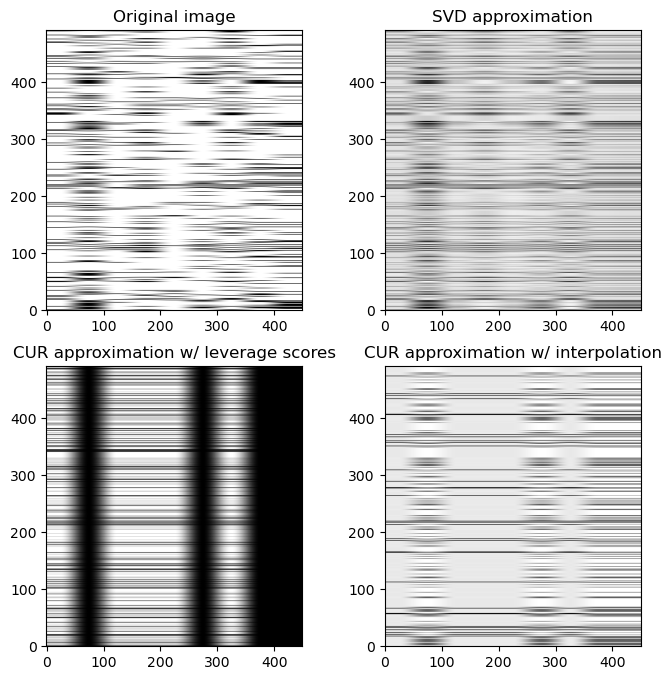

In [11]:
import pandas as pd

k = 2

c = pd.read_csv('supreme_court.csv')
A = c.to_numpy().astype(float)
(m, n) = A.shape
U, S, Vt = svds(A, k=k)

C1, U1, R1 = CUR_leverage(A,k)
C2, U2, R2 = CUR_interpolation(A,k)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(A, cmap='gray', extent=(-0.5, 50*n-0.5, -0.5, m-0.5))
plt.title('Original image')
plt.subplot(222)
plt.imshow((U@np.diag(S)@Vt), cmap='gray', extent=(-0.5, 50*n-0.5, -0.5, m-0.5))
plt.title('SVD approximation')
plt.subplot(223)
plt.imshow((C1@U1@R1), cmap='gray', extent=(-0.5, 50*n-0.5, -0.5, m-0.5))
plt.title('CUR approximation w/ leverage scores')
plt.subplot(224)
plt.imshow((C2@U2@R2), cmap='gray', extent=(-0.5, 50*n-0.5, -0.5, m-0.5))
plt.title('CUR approximation w/ interpolation')
plt.show()

In [12]:
A_svd = (U@np.diag(S)@Vt)
A_svd_01 = A_svd.copy()
A_svd_01[A_svd_01>=0.5] = 1
A_svd_01[A_svd_01<1] = 0

A_cur1 = (C1@U1@R1)
A_cur1_01 = A_cur1.copy()
A_cur1_01[A_cur1_01>=0.5] = 1
A_cur1_01[A_cur1_01<1] = 0

A_cur2 = (C2@U2@R2)
A_cur2_01 = A_cur2.copy()
A_cur2_01[A_cur2_01>=0.5] = 1
A_cur2_01[A_cur2_01<1] = 0

print("SVD approximation: ", 1. - np.count_nonzero(np.sum(np.abs(A-A_svd_01), axis=1)) / A.shape[0])
print("CUR approximation (leverage scores): ", 1. - np.count_nonzero(np.sum(np.abs(A-A_cur1_01), axis=1)) / A.shape[0])
print("CUR approximation (interpolation): ", 1. - np.count_nonzero(np.sum(np.abs(A-A_cur2_01), axis=1)) / A.shape[0])

SVD approximation:  0.5650406504065041
CUR approximation (leverage scores):  0.07113821138211385
CUR approximation (interpolation):  0.5040650406504066


### Points 2/2

## Total Points 20/20